# Advanced examples
The examples below show how to feed your own precomputed cosmological quantities, or use a mask (or even two different masks) to compute the SSC in partial sky

### Import modules

In [1]:
import math ; pi=math.pi
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
import time

In [2]:
# Import PySSC module
import PySSC

## Gaussian kernels

In [3]:
# Define redshift range
nz    = 500
z_arr = np.linspace(0,2,num=nz+1)[1:] # Redshifts must be > 0
zmin  = z_arr.min() ; zmax = z_arr.max()

In [4]:
sigmaz    = 0.05
zcenter_G = [0.4,0.55,0.7,0.85,1.,1.15,1.3,1.45,1.6]
nbins_G   = len(zcenter_G)
kernels_G = np.zeros((nbins_G,nz))
for i in range(nbins_G):
    kernels_G[i,:] = np.exp(-(z_arr-zcenter_G[i])**2/(2*sigmaz**2)) / np.sqrt(2*pi*sigmaz**2)

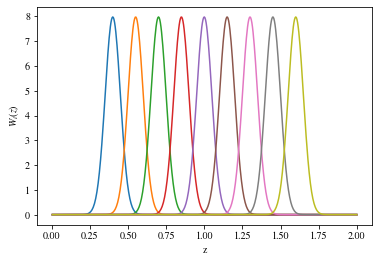

In [5]:
# Plot kernels
for i in range(nbins_G):
    plt.plot(z_arr,kernels_G[i,:])
plt.xlabel('z') ; plt.ylabel('$W_i(z)$')
plt.show()

## Use your own cosmology

Say you do not want PySSC to recompute (with CLASS) the cosmology : comoving distances, P(k) etc. \
For instance because you have already computed it, you study a non-standard model that is not supported by CLASS, or any other reason. \
Then you can input this cosmology to PySSC by creating an object with the same keys as the CLASS objects, and pass it to PySSC routines. \
In detail, if the object is called cosmo, the necessary keys are:
- cosmo.h giving the hubble factor 
- cosmo.z_of_r giving the comoving distance (in Mpc) and its derivative w.r.t. redshift 
- cosmo.pk(k,z) giving the (linear) matter power spectrum in Mpc^3 
- cosmo.scale_independent_growth_factor(z) giving the linear growth factor 

The format of these objects should be identical to the one of CLASS.

###### Example:
Let's precompute the cosmo with CLASS ourselves and feed it to PySSC

In [6]:
from classy import Class

In [7]:
#Precompute the cosmo
params = {'omega_b':0.022,'omega_cdm':0.12,'H0':67.,'n_s':0.96,'sigma8':0.81}
cosmo = Class()
dico4Class = params
dico4Class['output'] = 'mPk'
cosmo.set(dico4Class)
cosmo.compute()

In [8]:
#Feed it to PySSC: use the optional parameter cosmo_Class
t0 = time.process_time()
Sij_precomp = PySSC.Sij(z_arr,kernels_G,cosmo_Class=cosmo)
t1 = time.process_time()
print(t1-t0)

0.8779856890000008


In [9]:
#Compute the same matrix the standard way
t0 = time.process_time()
Sij_std = PySSC.Sij(z_arr,kernels_G,cosmo_params=params)
t1 = time.process_time()
print(t1-t0)

8.669232170999999


In [10]:
#Check the difference
diff = Sij_precomp - Sij_std
print(diff.min(),diff.max())

0.0 0.0


## Use a mask

In [11]:
# Mask files
masks_path   = './masks/'
mask_fullsky = masks_path+'full_sky_map.fits'
mask_DES     = masks_path+'DES-mask-simple-ring-1024.fits'

In [12]:
# Mask power spectra
import healpy as hp
# full sky
map_fullsky    = hp.read_map(str(mask_fullsky), dtype=np.float64, verbose=False)
nside_fullsky  = hp.pixelfunc.get_nside(map_fullsky) ; lmax_fullsky = 2*nside_fullsky
Cl_fullsky     = hp.anafast(map_fullsky, lmax=lmax_fullsky)
# DES
map_DES        = hp.read_map(str(mask_DES), dtype=np.float64, verbose=False)
nside_DES      = hp.pixelfunc.get_nside(map_DES) ; lmax_DES = 2*nside_DES
Cl_DES         = hp.anafast(map_DES, lmax=lmax_DES)
# DES x full sky
Cl_DES_fullsky = hp.anafast(map_DES, map2=map_fullsky,lmax=lmax_fullsky)

/home/fabien/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


### Mask=full sky, for comparison with previous routine

In [13]:
# Compute Sij with fullsky routine and with partial sky routine fed a fullsky mask
t0 = time.process_time()
Sij_full = PySSC.Sij(z_arr,kernels_G)
t1 = time.process_time()
Sij_psky = PySSC.Sij_psky(z_arr,kernels_G,clmask=Cl_fullsky)
t2 = time.process_time()
print('Sij full sky took: %.1f secs, partial sky %.1f secs' %(t1-t0,t2-t1))

Sij full sky took: 4.2 secs, partial sky 1.5 secs


100.0% of the part sky Sij bins are within 1% of the Sij full sky value


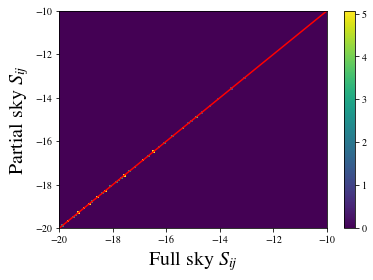

In [14]:
#Compare
plt.figure()
plt.hist2d(np.log(abs(Sij_full)).flatten(),np.log(abs(Sij_psky)).flatten(),bins=100,density=True,range=[[-20,-10],[-20,-10]])
plt.plot(np.linspace(-20,-10,100),np.linspace(-20,-10,100),color='r')
plt.xlabel(r'Full sky $S_{ij}$',fontsize=20)
plt.ylabel(r'Partial sky $S_{ij}$',fontsize=20)
plt.colorbar()
diff = (np.log(abs(Sij_full)) - np.log(abs(Sij_psky)))/np.log(abs(Sij_psky)) *100
print('%.1f%% of the part sky Sij bins are within 1%% of the Sij full sky value' %(np.sum(diff<=1.)/nbins_G**2 *100))

In [15]:
# Remark: feeding the entire mask instead of its Cl is slower, because PySSC needs to read the mask and compute its Cl
t0 = time.process_time()
Sij_cl = PySSC.Sij_psky(z_arr,kernels_G,clmask=Cl_fullsky)
t1 = time.process_time()
Sij_mask = PySSC.Sij_psky(z_arr,kernels_G,mask=mask_fullsky)
t2 = time.process_time()
print('With Cl as input: %.1f secs. With mask file as input: %.1f secs' %(t1-t0,t2-t1))

/home/fabien/.local/lib/python3.8/site-packages/healpy/fitsfunc.py:368: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


With Cl as input: 1.5 secs. With mask file as input: 74.2 secs


Remark 2: the Cl or the mask can be fed either as numpy array or as fits file in Healpix format

### DES-like mask

In [16]:
t0 = time.process_time()
Sij_DES = PySSC.Sij_psky(z_arr,kernels_G,clmask=Cl_DES)
t1 = time.process_time()
print('Computed in %.1f secs' %(t1-t0))

Computed in 30.8 secs


Mean relative difference: 3.16 %
Mean relative difference on the diagonal: 0.27 %


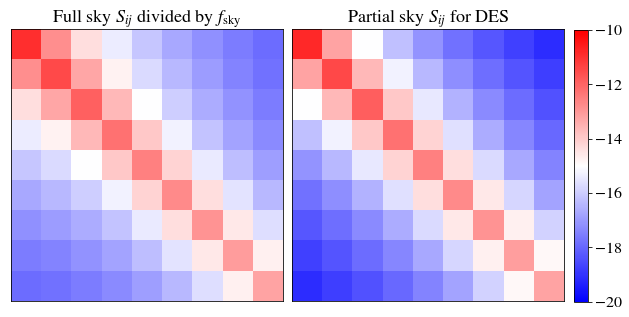

In [17]:
# Plot the DES matrix and compare with fullsky rescaled by sky fraction
f_sky = 0.1207
fig,axes = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'wspace':0.02})
im  = axes[0].imshow(np.log(abs(Sij_full/f_sky)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-10)
im2 = axes[1].imshow(np.log(abs(Sij_DES)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-10)
axes[0].set_title('Full sky $S_{ij}$ divided by $f_\mathrm{sky}$',fontsize=18)
axes[1].set_title('Partial sky $S_{ij}$ for DES',fontsize=18)
for ax in axes:
    ax.get_xaxis().set_ticks([]) ; ax.get_yaxis().set_ticks([])
cbar_ax = fig.add_axes([0.91, 0.124, 0.02, 0.755])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=1)
c_bar.ax.tick_params(labelsize=16)

print('Mean relative difference: %.2f %%' %(np.mean(abs((np.log10(abs(Sij_full/f_sky))-np.log10(abs(Sij_DES)))/np.log10(abs(Sij_DES))*100))))
print('Mean relative difference on the diagonal: %.2f %%' %(np.mean(abs((np.log10(abs(np.diag(Sij_full)/f_sky))-np.log10(abs(np.diag(Sij_DES))))/np.log10(abs(np.diag(Sij_DES)))*100))))

### DES x fullsky

In [18]:
# Fastest is to compute by feeding the cross-spectrum of the two masks
t0 = time.process_time()
Sij_DESxfull = PySSC.Sij_psky(z_arr,kernels_G,clmask=Cl_DES_fullsky)
t1 = time.process_time()
print('Computed in %.1f secs' %(t1-t0))

Computed in 1.5 secs


In [19]:
# Alternatively you can feed the two masks explicitely, it's just slower
t0 = time.process_time()
Sij_DESxfull_viamask = PySSC.Sij_psky(z_arr,kernels_G,mask=mask_DES,mask2=mask_fullsky)
t1 = time.process_time()
print('Computed in %.1f secs' %(t1-t0))
diffrel = (Sij_DESxfull_viamask-Sij_DESxfull)/Sij_DESxfull
print('Relative difference in the range:',diffrel.min(),diffrel.max())

Computed in 73.0 secs
Relative difference in the range: 0.0 0.0


Mean relative difference: 6.09 %
Mean relative difference on the diagonal: 7.34 %


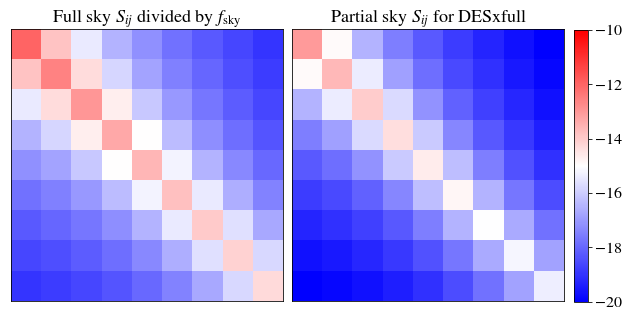

In [20]:
# Plot the DES matrix and compare with fullsky rescaled by sky fraction
f_sky_cross = np.sqrt(0.1207)
fig,axes = plt.subplots(1,2,figsize=(10,5),gridspec_kw={'wspace':0.02})
im  = axes[0].imshow(np.log(abs(Sij_full/f_sky_cross)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-10)
im2 = axes[1].imshow(np.log(abs(Sij_DESxfull)),interpolation='none',cmap='bwr',extent=[zmin,zmax,zmax,zmin],vmin=-20,vmax=-10)
axes[0].set_title('Full sky $S_{ij}$ divided by $f_\mathrm{sky}$',fontsize=18)
axes[1].set_title('Partial sky $S_{ij}$ for DESxfull',fontsize=18)
for ax in axes:
    ax.get_xaxis().set_ticks([]) ; ax.get_yaxis().set_ticks([])
cbar_ax = fig.add_axes([0.91, 0.124, 0.02, 0.755])
c_bar=fig.colorbar(im,cax=cbar_ax,fraction=1)
c_bar.ax.tick_params(labelsize=16)

print('Mean relative difference: %.2f %%' %(np.mean(abs((np.log10(abs(Sij_full/f_sky_cross))-np.log10(abs(Sij_DESxfull)))/np.log10(abs(Sij_DESxfull))*100))))
print('Mean relative difference on the diagonal: %.2f %%' %(np.mean(abs((np.log10(abs(np.diag(Sij_full)/f_sky_cross))-np.log10(abs(np.diag(Sij_DESxfull))))/np.log10(abs(np.diag(Sij_DESxfull)))*100))))